<a href="https://colab.research.google.com/github/ShinAsakawa/ShinAsakawa.github.io/blob/master/notebooks/2020_1003SRN_simulator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SRN simulator

<a href="http://www.cis.twcu.ac.jp/~asakawa/">浅川 伸一</a> &lt;asakawa@ieee.org&gt;

# SRN

SRN の基本は以下の式である。
\begin{equation}
\mathbf{y} = \sigma\left(\mathbf{Xw}_{in}+\mathbf{Hw}_{rec}+\mathbf{b}\right)
\end{equation}

ここで $\mathbf{X}$ はデータ行列で $n$ 行，$d$ 列 のデータ行列である。一時刻あたり一行のデータである。
時間発展を考えると $\mathbf{X}$ は逐次実行してまず $\mathbf{H}$ を作らなければならない。

In [ ]:
# ユーティリティ関数群を輸入するための Google Drive の認証をする準備
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth

from pydrive.drive import GoogleDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
# 認証キーを取得してください。komazawa-u.ac.jp のアカウントである必要があります。
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# Google Drive から zip ファイルを取得します
#https://drive.google.com/file/d/1k9i8hxUjF0bY9DWm1O_npdjCZd19C6FQ/view?usp=sharing
download = drive.CreateFile({'id': '1k9i8hxUjF0bY9DWm1O_npdjCZd19C6FQ'})
download.GetContentFile('__utils.py.zip')

In [ ]:
# 取得したファイルの展開
!unzip __utils.py.zip

In [ ]:
!apt-get install mecab libmecab-dev mecab-ipadic-utf8

In [ ]:
!pip install mecab-python3==0.7
import MeCab

In [ ]:
import MeCab
#wakati_parser = MeCab.Tagger('-d /usr/share/mecab/dic')
MeCab.Tagger('-Owakati').parse('インスタ映え').strip()


'インスタ 映え'

In [ ]:
# 必要なファイルの輸入
import os
import sys
import time
import numpy as np
import matplotlib.pyplot as plt

from __utils import xavier_initializer
from __utils import sigmoid, tanh, relu, elu, identity, softsign, softplus, sat, clu
from __utils import fc_layer, softmax_layer, srn_layer
#from __utils import fetch_mnist, view_mnist
from __utils import one_hot_vector, txt2data

In [ ]:
# 下準備
### preparation to draw graphs
plt.rcParams['figure.figsize'] = (12, 8) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

np.set_printoptions(precision=3, suppress=True)
np.random.seed(seed=None)

---

In [ ]:
# 実際の SRN の定義
class elman(object):
    """A simple elman network model demo.

    Parameters:
        hidden_layer_sizes : tuple, length = n_layers - 2, default (100,)
            The ith element represents the number of neurons in the ith
            hidden layer.

        activation : {identity, sigmoid, tanh, relu, elu, clu}, default tanh
            Activation function for the hidden layer.

        solver : {'sgd', 'adagrad', 'adadelta, 'rmsprop, 'adam', 'nadam'}, 
            default 'adam'.  The solver for weight optimization. 
            **NOT IMPLEMENTED**

        lambda_ : float, optional, default 1e-4
            L2 penalty (regularization term) parameter.

        lr : the learning ratio: float
        lr_init: float, default 1e-2
        
        random_state : int, RandomState instance or None, optional, default None
            If int, random_state is the seed used by the random number generator;
            If RandomState instance, random_state is the random number generator;
            If None, the random number generator is the RandomState instance used
            by `np.random`.

        tol : float, optional, default 1e-4
            Tolerance for the optimization. When the loss or score is not improving
            by at least tol for two consecutive iterations, unless `learning_rate`
            is set to 'adaptive', convergence is considered to be reached and
            training stops.

        verbose : bool, optional, default False
            Whether to print progress messages to stdout.

    """
    
    def __init__(self, X, y, \
                 n_hid=128, \
                 max_iter=1e+3, \
                 lr=1e-2, \
                 activation=tanh, \
                 verbose=False):
        self.max_iter = max_iter if max_iter is not None else 200
        self.n_hid = n_hid if n_hid is not None else 128
        self.X, self.y = np.copy(X), np.copy(y)
        self.activation = activation if activation is not None else tanh
        self.verbose = verbose if verbose is not None else False

        self.n_inp = self.X.shape[1]
        self.n_out = self.n_inp
        self.H = srn_layer(self.n_inp, self.n_hid, activation=activation)
        self.O = softmax_layer(self.n_hid, self.n_out)

    def fit(self, X, y, lr=1e-2, max_iter=1000, verbose=False):
        """Fit the model to data matrix X and target y.

        Parameters:
            X : array-like or sparse matrix, shape (n_samples, n_features)
                The input data.

            y : array-like, shape (n_samples,) or (n_samples, n_outputs)
                The target values (class labels in classification).

        Returns:
            self : returns a trained MLP model.
        """
        return self.train(X, y, max_iter=max_iter, verbose=verbose)
        #return self.train(self, X, y, lr=lr, max_iter=max_iter, verbose=verbose)

     
    def train(self, X, y, lr=1e-2, max_iter=1000, verbose=False):
        """Train the model to data matrix X and target y.

        Parameters:
            X : array-like or sparse matrix, shape (n_samples, n_features)
                The input data.

            y : array-like, shape (n_samples,) or (n_samples, n_outputs)
                The target values (class labels in classification).

        Returns:
            self : returns a trained the Elman network model.
        """
        X = self.X if X is None else X
        y = self.y if y is None else y
        verbose = verbose if verbose is not None else self.verbose
        max_iter = max_iter if max_iter is not None else self.max_iter
        hInit = np.zeros((1, self.n_hid),dtype=np.float32)
        state = np.zeros((X.shape[0],self.n_hid),dtype=np.float32)
        lossList = list()
        for iter in range(max_iter):
            inp = X
            Hout, state = self.H.forward(X, state, hInit)
            y_ = self.O.forward(Hout)

            Err = y_ - y
            loss = np.mean(Err**2)
            lossList.append(loss)
            if (iter % (max_iter>>3) == 0) and verbose:
                print('Iter={0:05d} loss={1:0.3f}'.format(iter, loss))
        
            delta = Err
            gradW2 = self.O.backward(delta, Hout)
            delta = np.dot(delta, self.O.W.T)
            gradW1, gradWr, _ = self.H.backward(X, state, delta)
    
            self.O.W -= lr * gradW2
            self.O.bias -= lr * np.mean(gradW2)
            self.H.W -= lr * gradW1
            self.H.bias -= lr * np.mean(gradW1)
            self.H.Wr -= lr * gradWr
        
        if verbose:
            plt.plot(lossList)
            plt.show()  
        return y_, lossList

    
    def predict(self, X):
        """Predict using this elman neural network.

        Parameters:
            X : {array-like, matrix}, shape (n_samples, n_features)
            The input data.

        Returns:
            y : array-like, shape (n_samples,) or (n_samples, n_classes)
            The predicted classes.
        """

        hInit = np.zeros((1, self.n_hid),dtype=np.float32)
        state = np.zeros((X.shape[0],self.n_hid),dtype=np.float32)
        Hout, state = self.H.forward(X, state, hInit)
        y_ = self.O.forward(Hout)
        return y_

    
    def predict_log_prob(self, X):
        """Return the log of probability estimates.

        Parameters:
            X : array-like, shape (n_samples, n_features)
                The input data.

        Returns:
            log_y_prob : array-like, shape (n_samples, n_classes)
                The predicted log-probability of the sample for each class
                in the model, where classes are ordered as they are in
                `self.classes_`. Equivalent to log(predict_proba(X))
        """
        yprob_ = self.predict_prob(X)
        return np.log(yprob_, out=yprob_)

    def predict_prob(self, X):
        """Probability estimates.

        Parameters:
            X : {array-like, sparse matrix}, shape (n_samples, n_features)
                The input data.

        Returns:
            y_prob : array-like, shape (n_samples, n_classes)
                The predicted probability of the sample for each class in the
                model, where classes are ordered as they are in `self.classes_`.
        """
        y_ = self._predict(X)

        if self.n_outputs_ == 1:
            y_ = y_.ravel()

        if y_.ndim == 1:
            return np.vstack([1 - y_, y_]).T
        else:
            return y_


In [ ]:
#!ls j_*.txt

!echo "日本国民は、正当に選挙された国会における代表者を通じて行動し、われらとわれらの子孫のために、諸国民との協和による成果と、わが国全土にわたつて自由のもたらす恵沢を確保し、政府の行為によつて再び戦争の惨禍が起ることのないやうにすることを決意し、ここに主権が国民に存することを宣言し、この憲法を確定する。" > j_constitution9.txt
!echo "そもそも国政は、国民の厳粛な信託によるものであつて、その権威は国民に由来し、その権力は国民の代表者がこれを行使し、その福利は国民がこれを享受する。" >> j_constitution9.txt
!echo "これは人類普遍の原理であり、この憲法は、かかる原理に基くものである。" >> j_constitution9.txt
!echo "われらは、これに反する一切の憲法、法令及び詔勅を排除する。" >> j_constitution9.txt
!echo "日本国民は、恒久の平和を念願し、人間相互の関係を支配する崇高な理想を深く自覚するのであつて、平和を愛する諸国民の公正と信義に信頼して、われらの安全と生存を保持しようと決意した。" >> j_constitution9.txt
!echo "われらは、平和を維持し、専制と隷従、圧迫と偏狭を地上から永遠に除去しようと努めてゐる国際社会において、名誉ある地位を占めたいと思ふ。" >> j_constitution9.txt
!echo "われらは、全世界の国民が、ひとしく恐怖と欠乏から免かれ、平和のうちに生存する権利を有することを確認する。" >> j_constitution9.txt
!echo "われらは、いづれの国家も、自国のことのみに専念して他国を無視してはならないのであつて、政治道徳の法則は、普遍的なものであり、この法則に従ふことは、自国の主権を維持し、他国と対等関係に立たうとする各国の責務であると信ずる。" >> j_constitution9.txt
!echo "日本国民は、国家の名誉にかけ、全力をあげてこの崇高な理想と目的を達成することを誓ふ。" >> j_constitution9.txt


In [ ]:
!ls *.txt
!cat j_constitution9.txt

j_constitution9.txt
日本国民は、正当に選挙された国会における代表者を通じて行動し、われらとわれらの子孫のために、諸国民との協和による成果と、わが国全土にわたつて自由のもたらす恵沢を確保し、政府の行為によつて再び戦争の惨禍が起ることのないやうにすることを決意し、ここに主権が国民に存することを宣言し、この憲法を確定する。
そもそも国政は、国民の厳粛な信託によるものであつて、その権威は国民に由来し、その権力は国民の代表者がこれを行使し、その福利は国民がこれを享受する。
これは人類普遍の原理であり、この憲法は、かかる原理に基くものである。
われらは、これに反する一切の憲法、法令及び詔勅を排除する。
日本国民は、恒久の平和を念願し、人間相互の関係を支配する崇高な理想を深く自覚するのであつて、平和を愛する諸国民の公正と信義に信頼して、われらの安全と生存を保持しようと決意した。
われらは、平和を維持し、専制と隷従、圧迫と偏狭を地上から永遠に除去しようと努めてゐる国際社会において、名誉ある地位を占めたいと思ふ。
われらは、全世界の国民が、ひとしく恐怖と欠乏から免かれ、平和のうちに生存する権利を有することを確認する。
われらは、いづれの国家も、自国のことのみに専念して他国を無視してはならないのであつて、政治道徳の法則は、普遍的なものであり、この法則に従ふことは、自国の主権を維持し、他国と対等関係に立たうとする各国の責務であると信ずる。
日本国民は、国家の名誉にかけ、全力をあげてこの崇高な理想と目的を達成することを誓ふ。


In [ ]:
clear(model)

filename=j_constitution9.txt
Iter=00000 loss=0.005
Iter=00012 loss=0.005
Iter=00024 loss=0.004
Iter=00036 loss=0.004
Iter=00048 loss=0.004
Iter=00060 loss=0.003
Iter=00072 loss=0.003
Iter=00084 loss=0.003
Iter=00096 loss=0.003


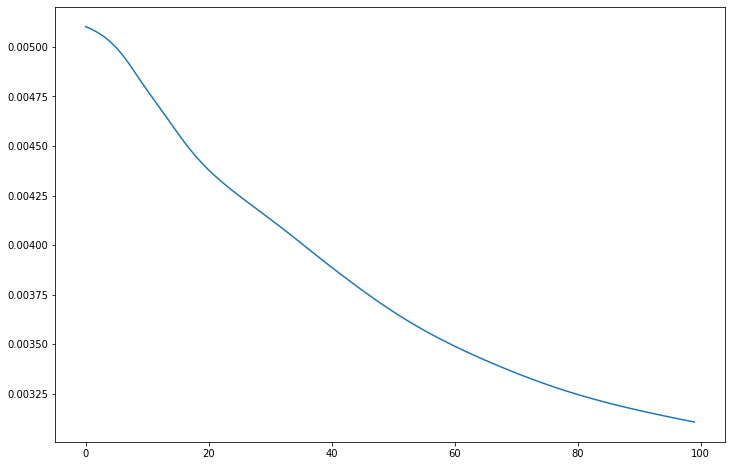

time elasped 211.8979160785675


In [ ]:
filename = 'j_constitution9.txt'
nHid = 128
activation = tanh
max_iter = 100
lr = 1e-1
X, y, idx2wrd, wrd2idx = txt2data(filename)
model = elman(X, y, n_hid=nHid, lr=lr, max_iter=max_iter, activation=activation)
start_time = time.time()
#y_, lossList = model.train(X, y, max_iter=max_iter,verbose=True)
y_, _ = model.fit(X, y, max_iter=max_iter, verbose=True)
end_time = time.time()
print('time elasped {}'.format(end_time - start_time))

In [ ]:
for x in [y, y_]:
    print('---\n')    
    for xi in x:
        print('{}'.format(idx2wrd[np.argmax(xi)]), end='')
    print()

In [ ]:
# このセルは無視してください
def main(filename=None, max_iter=1000, nHid=16, activation=tanh, lr=1e-2, verbose=False):
    X, y, idx2wrd, wrd2idx = txt2data(filename)
    model = elman(X, y, n_hid=nHid, lr=lr, max_iter=max_iter, activation=tanh, verbose=verbose)
    y_, lossList = model.train(X, y, max_iter=max_iter, verbose=verbose)
    
    return model, X, y_, lossList, idx2wrd, wrd2idx